In [223]:
# from CovidAnalysis import CovidAnalysis


In [226]:
from datetime import datetime,date,timedelta
import time
import numpy as np
import pandas as pd
import io
import warnings
warnings.filterwarnings('ignore')
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

import tensorflow as tf
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error;
from sklearn import preprocessing

# plotly library
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, RandomizedSearchCV;
from sklearn.linear_model import LinearRegression, BayesianRidge;
from sklearn.tree import DecisionTreeRegressor;
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

from fbprophet import Prophet
from scipy import integrate, optimize

import statsmodels.api as sm
import itertools

from sklearn.preprocessing import LabelEncoder
import xgboost

from pylab import rcParams

# matplotlib.rcParams['axes.labelsize'] = 14
# matplotlib.rcParams['xtick.labelsize'] = 12
# matplotlib.rcParams['ytick.labelsize'] = 12
# matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 18, 8


In [220]:
class CovidAnalysis:
    
    def __init__(self):
        self.statedf = None
        self._stateupdated = False
        self._processed = False
        self._today = date.today()
        self.scaler = MinMaxScaler(feature_range = (0,1))
        self.le = LabelEncoder()
        self.tol      = [1e-4, 1e-3, 1e-2]
        self.alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
        self.alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
        self.lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
        self.lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]
        self.bayesian_grid = {'tol': self.tol,
                         'alpha_1': self.alpha_1,
                         'alpha_2' : self.alpha_2,
                         'lambda_1': self.lambda_1,
                         'lambda_2' : self.lambda_2 }

    
    
    def todayDate(self):
        print("Today is:",self._today)
    
    def updateState(self,url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"):
        url = url
        s=requests.get(url).content
        self.statedf = pd.read_csv(io.StringIO(s.decode('utf-8')))
        self.statedf['date'] =  pd.to_datetime(self.statedf['date'], format='%Y-%m-%d')
        self._stateupdated = True
        
    def dateUpdate(self):
        if self._stateupdated:
            print("Date of the latest data:",self.statedf.iloc[-1]['date'].date())
        else:
            print("Data has not been updated even once!")
    
    def peek(self,val=5):
        if self._stateupdated:
            print("First "+str(val)+" rows of the state data")
            print("="*50)
            print(self.statedf.head(val))
       
    def process(self):
        pd.set_option('mode.chained_assignment', None)
        self.statedict= {}
        print("Processing...")
        t1 = time.time()
        if self._stateupdated:
            self.statelist = list(self.statedf['state'].unique())
            for s in self.statelist:
                state_df=self.statedf[self.statedf['state']==s]
                state_df['newcases'] = state_df['cases'].diff()
                state_df['newdeaths'] = state_df['deaths'].diff()
                self.statedict[s]=state_df
        self._processed = True
        t2 = time.time()
        delt = round(t2-t1,3)
        print("Finished. Took {} seconds".format(delt))
    

    
    def TopStatewithmostSituation(self,feature_col="cases"):
            
            title = 'Top 10 states with highest number of Death Cases'
            if feature_col == "cases":
                title = 'Top 10 states with highest number of Confirmed Cases'
            df_State = self.statedf.groupby(['state'])[[feature_col]].max().nlargest(10,feature_col)
            fig = px.bar(df_State.sort_values(feature_col,ascending=True)[:20][::-1],x=feature_col,y=df_State.index,title=title,text=df_State[feature_col], height=900, orientation='h')
            plotly.offline.iplot(fig)
    
    def plot_state(self,
                   state='New York',
                   last_30_days=False):
        """
        Plots statewise data
        """
        if self._processed==False:
            print("Data not processed yet. Cannot plot statewise.")
            return None
        
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        df = self.statedict[s]
        
        dates = df['date']
        cases = df['cases']
        deaths = df['deaths']
        newcases = df['newcases']
        newdeaths = df['newdeaths']
        
        if last_30_days:
            dates = df['date'][-31:-1]
            cases = df['cases'][-31:-1]
            deaths = df['deaths'][-31:-1]
            newcases = df['newcases'][-31:-1]
            newdeaths = df['newdeaths'][-31:-1]
        title= ""
        if last_30_days:
            title = "Cumulative cases in {}, for last 30 days".format(s)
        else:
            title = "Cumulative cases in {}".format(s)
            
        fig = px.bar(df, x=dates, y=cases)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of confirmed cases")
        fig.update_layout(layout)
        fig.show()
        
        print()
        
        if last_30_days:
            title = "Cumulative deaths in {}, for last 30 days".format(s)
        else:
            title = "Cumulative deaths in {}".format(s)
        fig = px.bar(df, x=dates, y=deaths)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of Death cases")
        fig.update_layout(layout)
        fig.show()
    
        
        print()
        
        if last_30_days:
            title = "New cases in {}, for last 30 days".format(s)
        else:
            title = "New cases in {}".format(s)
            
        fig = px.bar(df, x=dates, y=newcases)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of New cases")
        fig.update_layout(layout)
        fig.show()
       
        print()
        
        if last_30_days:
            title = "New deaths in {}, for last 30 days".format(s)
        else:
            title = "New deaths in {}".format(s)
        fig = px.bar(df, x=dates, y=newdeaths)
        layout = go.Layout(title=go.layout.Title(
                text=title,x=0.5),font=dict(size=14),width=800,height=600,
                           xaxis_title = "Date of observation",
                           yaxis_title = "Number of New Death cases")
        fig.update_layout(layout)
        fig.show()
     
    def plot_multi_state(self, 
                         states = ['California','Michigan','New York'],
                         last_30_days=False):
        """
        Plots multiple states data in a single plot for comparison
        """
        states = states
        if last_30_days:
            colors=[]
            data =[]
            for s in states:
                color = tuple(np.round(np.random.random(3),2))
                colors.append(color)
                data.append(go.Scatter(
                        x = self.statedict[s]['date'][-31:-1],
                        y = self.statedict[s]['cases'][-31:-1],
                        mode = "lines",
                        name = s,
                        marker = dict(color = color),
                        text= s))
            layout = dict(title = 'Cumulative cases, for last 30 days',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
            fig = dict(data = data, layout = layout)
            iplot(fig)
        else:
            colors=[]
            data =[]
            for s in states:
                color = tuple(np.round(np.random.random(3),2))
                colors.append(color)
                data.append(go.Scatter(
                        x = self.statedict[s]['date'],
                        y = self.statedict[s]['cases'],
                        mode = "lines",
                        name = s,
                        marker = dict(color = color),
                        text= s))
            layout = dict(title = 'Cumulative cases',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
            fig = dict(data = data, layout = layout)
            iplot(fig)
            
        
    def rankTopStates(self,
                  N=5,
                  daterank=None):
        """
        Ranks the states in a bar chart
        Arguments:
            N: Top N states to be ranked
            date: Date at which the ranking is done.Must be a string in the form '2020-3-27'
        """
        cases = {}
        deaths = {}
        newcases = {}
        newdeaths = {}

        if daterank==None:
            d = self.statedf.iloc[-1]['date'].date()
        else:
            d = datetime.datetime.strptime(daterank,'%Y-%m-%d').date()

        for s in self.statedict:
            df=self.statedict[s]
            for i in range(len(df)):
                if df['date'].iloc[i].date()==d:
                    cases[s]=df.iloc[i]['cases']
                    deaths[s]=df.iloc[i]['deaths']
                    newcases[s]=df.iloc[i]['newcases']
                    newdeaths[s]=df.iloc[i]['newdeaths']

        sorted_cases = sorted(((value, key) for (key,value) in cases.items()),reverse=True)
        sorted_cases = sorted_cases[:N]
        sorted_deaths = sorted(((value, key) for (key,value) in deaths.items()),reverse=True)
        sorted_deaths = sorted_deaths[:N]
        sorted_newcases = sorted(((value, key) for (key,value) in newcases.items()),reverse=True)
        sorted_newcases = sorted_newcases[:N]
        sorted_newdeaths = sorted(((value, key) for (key,value) in newdeaths.items()),reverse=True)
        sorted_newdeaths = sorted_newdeaths[:N]

        fig = make_subplots(rows=2, cols=2,subplot_titles=(
            "Cumulative cases on {}".format(str(d)),"Cumulative deaths on {}".format(str(d)),
            "New cases on {}".format(str(d)), "New deaths on {}".format(str(d))))

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_cases],
                y=[val[0] for val in sorted_cases]),
              row=1, col=1)
        fig.add_trace(go.Bar(x=[val[1] for val in sorted_deaths],
                y=[val[0] for val in sorted_deaths]),
              row=1, col=2)

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_newcases],
                y=[val[0] for val in sorted_newcases]),
              row=2, col=1)

        fig.add_trace(go.Bar(x=[val[1] for val in sorted_newdeaths],
                y=[val[0] for val in sorted_newdeaths]),
              row=2, col=2)

        fig.update_layout(height=600, width=800,
                  title_text="Multiple Subplots with Titles")

        fig.show()
    
    def PieChart(self,feature_col):
        fig = px.pie(self.statedf, values=feature_col, names='state')
        fig.update_traces(textposition='inside')
        fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
        fig.show()
    
    def TreeMap(self,feature_col):
        title = "Current Statewise COVID19 " + feature_col +"cases"
        if feature_col == 'cases' :
            title = "Current Statewise COVID19 " + feature_col
            
        fig = px.treemap(self.statedf, path=['state'], values=feature_col,color=feature_col, hover_data=['state'],
                  color_continuous_scale='matter', title='Current share of Statewise COVID19 '+str(feature_col))
        fig.show()
    
    def RegressionFeatures(self,state="New York",feature_col="cases"):

        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert feature_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        
        df = self.statedict[s]
        date_lst = df["date"]
#         print(date_lst)
        growth_len_lst = len(date_lst) - 1
        confirmed_lst = df["cases"].values;
        death_lst = df["deaths"].values;
        confGF_lst = []
        deathsGF_lst = []
        df_date_tots = df
        data =[]
        for i in range(growth_len_lst):
            confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] ;
            confGF_lst.append(confirmedGF)
            deathGF = death_lst[i+1] / death_lst[i] ;
            deathsGF_lst.append(deathGF)
        days_since_lst = [];
        for i in range(len(date_lst)):
            days_since_lst.append(i);
        df_date_tots["Days Since:"] = days_since_lst;
        df_date_tots = df_date_tots[["Days Since:", "cases", "deaths"]];
        
        data.append(go.Scatter(
                        x =days_since_lst,
                        y=confGF_lst,
                        mode = "lines",
                        name="confidenceGrowth",
                        text= "Growth Factor of Confirmed Cases"))
        
        data.append(go.Scatter(
                        x =days_since_lst,
                        y = deathsGF_lst,
                        mode = "lines",
                        name="deathGrowth",
                        text= "Growth Factor of Deaths "))
        x = []
        for i in range((growth_len_lst)):
            x.append(1);
        data.append(go.Scatter(
                        x =days_since_lst,
                        y =x,
                        mode = "lines",
                        name="GrowthFactor=1",
                        text= "Growth Factor = 1.0"))
        
        X = np.array(df_date_tots[feature_col])
        y = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
        layout = dict(title = 'Cumulative cases',xaxis= dict(title= 'Date',ticklen= 5,zeroline= False))
        fig = dict(data = data, layout = layout)
        iplot(fig)
#         print(data)
        return (X,y)
        
    def LinearRegression(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        lin_model = LinearRegression(normalize = True, fit_intercept = False);
        lin_model.fit(y_train, X_train);
        test_lin_pred = lin_model.predict(y_test)
        lin_pred = lin_model.predict(y)
        plt.figure(figsize = [15,5]);
        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        # plotting the predicited values for the future days
        plt.plot(y_test,
                 test_lin_pred,
                 label = "Line Regression predicted Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error (test_lin_pred, X_test))
        print('MSE:', mean_squared_error  (test_lin_pred, X_test))
        
        plt.figure(figsize=(15, 5))
        plt.plot(y,X,label = 'Actual Future Cases',color = 'crimson')
        plt.plot(y_train,X_train,label = 'Training Cases',color = 'lightgrey')
        plt.plot(y,lin_pred,label = 'Linear Prediction of Future Cases',linestyle = "dashed",color = 'gold')
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
    def PolynomialRegression(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        poly = PolynomialFeatures(degree=7)
        poly_y_train = poly.fit_transform(y_train)
        poly_y_test  = poly.fit_transform(y_test)
        poly_y = poly.fit_transform(y)
        linear_model = LinearRegression(normalize=True, fit_intercept=False)
        linear_model.fit(poly_y_train, X_train)
        test_linear_pred = linear_model.predict(poly_y_test)
        linear_pred = linear_model.predict(poly_y)
        plt.figure(figsize = [15,5]);
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        plt.plot(y_test,
                 test_linear_pred,
                 label = "Polynomial Regression Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error(test_linear_pred, X_test))
        print('MSE:',mean_squared_error(test_linear_pred, X_test))
        
        
        plt.figure(figsize=(15, 5))
        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')

        plt.plot(y,
                 linear_pred,
                 label = 'Polynomial Regression Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')

        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')

        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
    def RidgeRegression(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        
        bayesian = BayesianRidge(fit_intercept=False, normalize=True)
        bayesian_search = RandomizedSearchCV(bayesian,
                                             self.bayesian_grid,
                                             scoring='neg_mean_squared_error',
                                             cv=3,
                                             return_train_score=True,
                                             n_jobs=-1,
                                             n_iter=40,
                                             verbose=1)

        bayesian_search.fit(y_train, X_train);

        print(bayesian_search.best_params_)
        y_test_ridge_pred = bayesian_search.predict(y_test);
        y_ridge_pred = bayesian_search.predict(y);
        plt.figure(figsize = [15,5]);
        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        # plotting the predicited values for the future days
        plt.plot(y_test,
                 y_test_ridge_pred,
                 label = "Ridge predicted Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
        print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

        plt.figure(figsize=(15, 5))
        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')
        plt.plot(y,
                 y_ridge_pred,
                 label = 'Ridge Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')
        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')
        #plt.title('# of Coronavirus Cases Over Time', size=30)
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
    def PolynomialRidgeRegression(self,X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        bayesian = BayesianRidge(fit_intercept=False, normalize=True)
        poly = PolynomialFeatures(degree=10)
        poly_y_train = poly.fit_transform(y_train)
        poly_y_test  = poly.fit_transform(y_test)
        poly_y = poly.fit_transform(y)
        bayesian_search_poly = RandomizedSearchCV(bayesian,
                                     self.bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)
        bayesian_search_poly.fit(poly_y_train, X_train);
        print(bayesian_search_poly.best_params_)
        bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
        test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
        bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_y)
        plt.figure(figsize = [15,5]);
        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')
        # plotting the predicited values for the future days
        plt.plot(y_test,
                 test_poly_bayesian_pred,
                 label = "Ridge Polynomial predicted Confirmed Cases",
                 color = 'gold')
        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, X_test))
        print ('MSE:', mean_squared_error (test_poly_bayesian_pred, X_test))
        
        plt.figure(figsize=(15, 5))
        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')
        plt.plot(y,
                 bayesian_poly_pred,
                 label = 'Ridge Polynomial Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')
        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')
        #plt.title('# of Coronavirus Cases Over Time', size=30)
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        #plt.grid()
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
        
    def DecisionTree(self,X,y):
        
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15,shuffle = False)
        DT_reg = DecisionTreeRegressor(random_state=0);
        DT_reg.fit(y_train, X_train);
        y_test_DT_pred = DT_reg.predict(y_test);
        y_DT_pred = DT_reg.predict(y);
        plt.figure(figsize = [15,5]);

        # plotting the actual values for the future days
        plt.plot(y_test,
                 X_test,
                 label = "Actual Confirmed Cases",
                 color = 'crimson')

        # plotting the predicited values for the future days
        plt.plot(y_test,
                 y_test_DT_pred,
                 label = "Dec Tree predicted Confirmed Cases",
                 color = 'gold')

        plt.grid();
        plt.legend();
        plt.xlabel("Day", size = 25)
        plt.ylabel("Count", size = 25)
        plt.xticks(rotation = 90, size = 15);
        plt.show()

        print('MAE:', mean_absolute_error(y_test_DT_pred, X_test))
        print('MSE:',mean_squared_error(y_test_DT_pred, X_test))
        
        plt.figure(figsize=(15, 5))

        plt.plot(y,
                 X,
                 label = 'Actual Future Cases',
                 color = 'crimson')

        plt.plot(y_train,
                 X_train,
                 label = 'Training Cases',
                 color = 'lightgrey')

        plt.plot(y,
                 y_DT_pred,
                 label = 'Dec Tree Prediction of Future Cases',
                 linestyle = "dashed",
                 color = 'gold')

        #plt.title('# of Coronavirus Cases Over Time', size=30)
        plt.xlabel('Days Since', size = 30)
        plt.ylabel('# of Cases', size = 30)
        plt.legend()
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.show()
        
        
    def createDataset(self,train) : 
        train_scaled = self.scaler.fit_transform(train)
        x_train = [] 
        y_train = []
        time_step = 2
        
        for i in range(time_step, train_scaled.shape[0]):
            x_train.append(train_scaled[i-time_step : i , 0])
            y_train.append(train_scaled[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1 ))
        y_train = np.reshape(y_train, (y_train.shape[0], 1 ))

        return x_train, y_train     
    
    def TestTrainSplit(self,state='New York'):
        if self._processed==False:
            print("Data not processed yet. Cannot plot statewise.")
            return None
    
        s = str(state)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        df = self.statedict[s]
        df["cases"] = df["cases"].astype(int)
        df["deaths"] = df["deaths"].astype(int)
        train_data_size = int(len(df) * 0.75)
        test_data_size = len(df) - train_data_size
#         print("Training size = {}".format(train_data_size))
#         print("Validation size = {}".format(test_data_size))
        
        dates = df['date']
        cases = df['cases']
        deaths = df['deaths']
        newcases = df['newcases']
        newdeaths = df['newdeaths']

        train_data_confirmed_cases = cases.iloc[0:train_data_size]
        val_data_confirmed_cases= cases.iloc[train_data_size : len(cases)]
#         print(train_data_confirmed_cases.values)
#         print(val_data_confirmed_cases)
        
        train_data_fatal_cases = deaths.iloc[0:train_data_size]
        val_data_fatal_cases = deaths.iloc[train_data_size : len(deaths)]

        
        return (train_data_confirmed_cases,val_data_confirmed_cases,train_data_fatal_cases,val_data_fatal_cases)
    
    def PredictionwithLSTM(self,x_train,y_train,x_val,y_val,casetype="cases"):
        
        EPOCHS = 100
        BATCH_SIZE = 32
        model=self.modelLSTM(x_train)
        with tf.device("/device:CPU:0"):
            history = model.fit(x_train, y_train,epochs = EPOCHS, verbose = 1,batch_size = BATCH_SIZE, validation_data = (x_val, y_val))
        predicted_cases = model.predict(x_val)
        predicted_cases = self.scaler.inverse_transform(predicted_cases)
        real_cases = self.scaler.inverse_transform(y_val)
        plt.figure(figsize= (12, 8))
        plt.subplot(1,1,1)
        title = "Real Number Of Confirmed Cases"
        predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
        realTitle = "Corona Confirmed Cases"
        if casetype== "deaths":
            title = "Real Number of Fatalities Cases"
            predictedtitle = "Predicted Number  Of Fatalities Cases (Validation set)"
            realTitle = "Corona Fatal Cases"

        plt.plot(real_cases, color = "red", label = title)
        plt.plot(predicted_cases, color = "blue", label = predictedtitle)
        plt.title(realTitle)
        plt.xlabel("Days")
        plt.ylabel("Case Count")
        plt.legend()
        plt.grid("both")
        plt.show()
        
    def modelLSTM(self,x_train):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(units = 30, return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.3))
        model.add(tf.keras.layers.LSTM(units = 50, return_sequences = False))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Dense(units = 1))
        model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")
        model.summary()
        return model
    
        # Susceptible equation
    def fa(self,N, a, b, beta):
        fa = -beta*a*b
        return fa

    # Infected equation
    def fb(self,N, a, b, beta, gamma):
        fb = beta*a*b - gamma*b
        return fb

    # Recovered/deceased equation
    def fc(self,N, b, gamma):
        fc = gamma*b
        return fc

    # Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
    def rK4(self,N, a, b, c, fa, fb, fc, beta, gamma, hs):
        a1 = self.fa(N, a, b, beta)*hs
        b1 = self.fb(N, a, b, beta, gamma)*hs
        c1 = self.fc(N, b, gamma)*hs
        ak = a + a1*0.5
        bk = b + b1*0.5
        ck = c + c1*0.5
        a2 = self.fa(N, ak, bk, beta)*hs
        b2 = self.fb(N, ak, bk, beta, gamma)*hs
        c2 = self.fc(N, bk, gamma)*hs
        ak = a + a2*0.5
        bk = b + b2*0.5
        ck = c + c2*0.5
        a3 = self.fa(N, ak, bk, beta)*hs
        b3 = self.fb(N, ak, bk, beta, gamma)*hs
        c3 = self.fc(N, bk, gamma)*hs
        ak = a + a3
        bk = b + b3
        ck = c + c3
        a4 = self.fa(N, ak, bk, beta)*hs
        b4 = self.fb(N, ak, bk, beta, gamma)*hs
        c4 = self.fc(N, bk, gamma)*hs
        a = a + (a1 + 2*(a2 + a3) + a4)/6
        b = b + (b1 + 2*(b2 + b3) + b4)/6
        c = c + (c1 + 2*(c2 + c3) + c4)/6
        return a, b, c

    def SIR(self,N, b0, beta, gamma, hs):

        """
        N = total number of population
        beta = transition rate S->I
        gamma = transition rate I->R
        k =  denotes the constant degree distribution of the network (average value for networks in which 
        the probability of finding a node with a different connectivity decays exponentially fast
        hs = jump step of the numerical integration
        """

        # Initial condition
        a = float(N-1)/N -b0
        b = float(1)/N +b0
        c = 0.

        sus, inf, rec= [],[],[]
        for i in range(10000): # Run for a certain number of time-steps
            sus.append(a)
            inf.append(b)
            rec.append(c)
            a,b,c = self.rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

        return sus, inf, rec

    
    
    def SimpleRegression(self,stateName,forecast_col='cases',forecast_days=30):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"

        df = self.statedict[s]
        df.dropna(subset = ["newcases","newdeaths"], inplace=True)
        print(type(df))
        regressionData = pd.DataFrame(columns=['date','cases','deaths', 'newcases', 'newdeaths'],data=df[['date','cases','deaths', 'newcases', 'newdeaths']].values)
        regressionData.head()

        regressionData['date'] = pd.to_datetime(regressionData['date'])
        regressionData = regressionData.set_index('date')
        regressionData.head()

        #Plot the graph
#         regressionData['cases'].plot(figsize=(12,5), color="green")
#         plt.legend(loc=4)
#         plt.xlabel('Date')
#         plt.ylabel('Cases')
#         plt.show()

#         regressionData['deaths'].plot(figsize=(12,5), color="red")
#         plt.xlabel('Date')
#         plt.ylabel('Death')
#         plt.show()

#         regressionData['newcases'].plot(figsize=(12,5), color="blue")
#         plt.xlabel('Date')
#         plt.ylabel('New Cases')
#         plt.show()
        forecast_out = int(forecast_days)
        print('length =',len(regressionData), "and forecast_out =", forecast_out)

        regressionData['temp'] = regressionData[forecast_col].shift(-forecast_out)


        # Define features Matrix X by excluding the label column which we just created 
        X = np.array(regressionData.drop(['temp'], 1))

        # Using a feature in sklearn, preposessing to scale features
        X = preprocessing.scale(X)
        print(X[1,:])

        # X contains last 'n= forecast_out' rows for which we don't have label data
        # Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

        X_forecast_out = X[-forecast_out:]
        X = X[:-forecast_out]
        print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

        # Define vector y

        # Define vector y for the data we have prediction for
        # make sure length of X and y are identical
        y = np.array(regressionData['temp'])
        y = y[:-forecast_out]
        print('Length of y: ',len(y))

        # split into test and train data


        # (split into test and train data)
        # test_size = 0.2 ==> 20% data is test data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        print('length of X_train and x_test: ', len(X_train), len(X_test))

        # Create linear regression object
        lr = LinearRegression()

        # Train the model using the training sets
        lr.fit(X_train, y_train)
        # Test
        accuracy = lr.score(X_test, y_test)
        print("Accuracy of Linear Regression: ", accuracy)


        # Predict using our Model
        forecast_prediction = lr.predict(X_forecast_out)
        print(forecast_prediction)

        last_date = regressionData.iloc[-1].name 
        last_date

        todays_date = datetime.strptime(last_date.strftime("%Y-%m-%d"), "%Y-%m-%d")
        todays_date = todays_date + timedelta(days=1)
        todays_date = datetime.strptime(todays_date.strftime("%Y-%m-%d"), "%Y-%m-%d")
        index = pd.date_range(todays_date, periods=30, freq='D')
        columns = ['date','cases','deaths', 'newcases', 'newdeaths','forecast']
        temp_df = pd.DataFrame(index=index, columns=columns)
        temp_df

        j=0
        for i in forecast_prediction:
            temp_df.iat[j,len(columns)-1] = i
            j= j+1

        temp_df
        # Plotting the Prediction
        
        regressionData[forecast_col].plot()
        temp_df['forecast'].plot()
        plt.xlabel('Date')
        plt.ylabel(forecast_col)
        plt.show()
        
    def ProphetPrediction(self,stateName,forecast_col='cases',forecast_days=30):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"

        df = self.statedict[s]
        df.dropna(subset = ["newcases","newdeaths"], inplace=True)
        print(type(df))
        df_data = df[["date",forecast_col]]
        df_data.rename(columns={'date': 'date',forecast_col:'y'}, inplace=True)
        df_data.columns = ['ds', 'y']
        df_data.tail()
        ML_Model = Prophet(interval_width=0.95)
        #Fit the Model
        ML_Model.fit(df_data)
        #Create prediction Data
        model_Prediction = ML_Model.make_future_dataframe(periods=60)
        model_Prediction.tail()
        #predicting the future with date, and upper and lower limit of y value
        modelForecast = ML_Model.predict(model_Prediction)
        modelForecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
#         modelForecasting = ML_Model.plot(modelForecast)
        yhat = go.Scatter(x = modelForecast['ds'],
          y = modelForecast['yhat'],mode = 'lines',marker = {'color': '#3bbed7'},
          line = {'width': 3},name = 'Forecast')

        yhat_lower = go.Scatter(x = modelForecast['ds'],y = modelForecast['yhat_lower'],
          marker = {'color': 'rgba(0,0,0,0)'},
          showlegend = False,hoverinfo = 'none')

        yhat_upper = go.Scatter(x = modelForecast['ds'],
          y = modelForecast['yhat_upper'],fill='tonexty',
          fillcolor = 'rgba(231, 234, 241,.75)',name = 'Confidence',
          hoverinfo = 'none',mode = 'none')

        actual = go.Scatter(x = df_data['ds'],
          y = df_data["y"],mode = 'markers',
          marker = {
            'color': '#fffaef',
            'size': 4,
            'line': {
              'color': '#000000',
              'width': .75
            }
          },
          name = 'Actual'
        )

        layout = go.Layout(
          yaxis = {
            'title': "y",
            'tickformat': format("y"),
            'hoverformat': format("y")
          },
          hovermode = 'x',
          xaxis = {
            'title': "x"
          },
          margin = {
            't': 20,
            'b': 50,
            'l': 60,
            'r': 10
          },
          legend = {
            'bgcolor': 'rgba(0,0,0,0)'
          }
        )
        data = [yhat_lower, yhat_upper, yhat, actual]

        fig = dict(data = data, layout = layout)
        plotly.offline.iplot(fig)

    def PredictionSIR(self,population,stateName,forecast_col='cases'):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
    #         print(list(n.statedict[s].columns))
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        df = self.statedict[s]
        print(df)
        SIR_df = pd.DataFrame()
        SIR_df[forecast_col] =df[forecast_col].diff().fillna(0)
        SIR_df= SIR_df[10:] 
        SIR_df['day_count'] = list(range(1,len(SIR_df)+1))

        ydata = [i for i in SIR_df[forecast_col]]
        xdata = SIR_df.day_count
        ydata = np.array(ydata, dtype=float)
        xdata = np.array(xdata, dtype=float)
        def sir_model(y, x, beta, gamma):
            sus = -beta * y[0] * y[1] / N
            rec = gamma * y[1]
            inf = -(sus + rec)
            return sus, inf, rec

        def fit_odeint(x, beta, gamma):
            print(sus0,inf0,rec0)
            return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]
        
        N = population
        inf0 = ydata[0]
        sus0 = N - inf0
        rec0 = 0.0

        popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
        fitted = fit_odeint(xdata, *popt,)

        plt.plot(xdata, ydata, 'o')
        plt.plot(xdata, fitted)
        plt.title("Fit of SIR model for "+ stateName +" "+ forecast_col)
        plt.ylabel("Population "+forecast_col)
        plt.xlabel("Days")
        plt.show()
        print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
        
    def ARIMAPrediction(self,stateName,forecast_col='cases',start_date='2020-20-10'):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        
        df = self.statedict[s].copy(deep=True)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)    
        timeSeries =df[forecast_col]
        decomposition = sm.tsa.seasonal_decompose(timeSeries, model='additive')
        fig = decomposition.plot()
        plt.show()
        p = d = q = range(0, 2)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#         print('Examples of parameter combinations for Seasonal ARIMA...')
#         print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#         print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#         print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#         print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = sm.tsa.statespace.SARIMAX(timeSeries,order=param,seasonal_order=param_seasonal,
                        enforce_stationarity=False,enforce_invertibility=False)
                    results = mod.fit()
#                     print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
                except:
                    continue
        mod = sm.tsa.statespace.SARIMAX(timeSeries,order=(1, 1, 1),seasonal_order=(0, 1, 1, 12),
                                        enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
#         print(results.summary().tables[1])
        results.plot_diagnostics(figsize=(16, 8))
        plt.show()
        pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
        pred_ci = pred.conf_int()

        ax = timeSeries.plot(label=forecast_col)
        pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
        ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1],color='k',alpha=.2)

        ax.set_xlabel('Date')
        ax.set_ylabel("Forecast"+str(forecast_col))
        plt.legend()
        plt.show()
    
    
    def FeatureLabelEncoder(self,df):
        for c in df.columns:
            if df.dtypes[c] == object:
                self.le.fit(df[c].astype(str))
                df[c] = self.le.transform(df[c].astype(str))
        return df

    def create_time_features(self,df):
        """
        Creates time series features from datetime index
        """
        df['date'] = df.index
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek
        df['quarter'] = df['date'].dt.quarter
        df['month'] = df['date'].dt.month
        df['year'] = df['date'].dt.year
        df['dayofyear'] = df['date'].dt.dayofyear
        df['dayofmonth'] = df['date'].dt.day
        df['weekofyear'] = df['date'].dt.weekofyear

        X = df[['hour','dayofweek','quarter','month','year',
               'dayofyear','dayofmonth','weekofyear']]
        return X

    def PredictionXGBOOST(self,stateName,forecast_col='cases'):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        assert forecast_col in list(self.statedict[s].columns) ,"Forecast Column does not appear to be the column in the states Dataframe. Possibly wrong name/spelling"
        
        df = self.statedict[s].copy(deep=True)
        print(df)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)  
        rng = pd.date_range(start=df.index.max(), periods=25)
        predictionDates = pd.DataFrame({ 'date': rng })
        print(predictionDates)
        predictionDates.set_index('date',inplace=True)
        self.create_time_features(df).head()
        self.create_time_features(predictionDates).head()
        df.drop("date", axis=1, inplace=True)
        predictionDates.drop("date", axis=1, inplace=True)
        corr_Features=df.corr()[forecast_col]
        corr_Features.sort_values(ascending=False)
        df.drop("hour", axis=1, inplace=True)
        predictionDates.drop("hour", axis=1, inplace=True)
        df.drop("dayofweek", axis=1, inplace=True)
        predictionDates.drop("dayofweek", axis=1, inplace=True)
        df.drop("quarter", axis=1, inplace=True)
        predictionDates.drop("quarter", axis=1, inplace=True)
        df.drop("year", axis=1, inplace=True)
        predictionDates.drop("year", axis=1, inplace=True)
        df.drop("fips", axis=1, inplace=True)
        train = self.FeatureLabelEncoder(df)
        train.info()
        test = self.FeatureLabelEncoder(predictionDates)
        test.info()
        x_train= train[[ 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
        y1 = train[[forecast_col]]
#         y2 = train[['deaths']]
        x_test = test[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
        model = xgboost.XGBRegressor()
        model.fit(x_train,y1)
        prediction1 = model.predict(x_test)
        prediction1 = pd.DataFrame(prediction1)
        print(prediction1)
        prediction1.columns = [forecast_col+"prediction"]

#         plt.plot(train[[forecast_col]].values, color = "blue", label = 'title')
        plt.plot(prediction1, color = "red", label = 'Prediction for next upcoming days')
    

    def AnnModel(self,X,Y):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(units = 128 ,activation = 'relu'))
        model.add(tf.keras.layers.Dense(units = 64 ,activation = 'sigmoid'))
        model.add(tf.keras.layers.Dense(units = 16 ,activation = 'relu'))
        model.add(tf.keras.layers.Dense(units = 8 ,activation = 'sigmoid'))
        model.add(tf.keras.layers.Dense(units=1))
        model.compile(optimizer =  'adam', loss = 'mean_squared_error',metrics=['accuracy'])
        model.fit(X,Y,batch_size=32,epochs=150)
        return model


    def PredictionAnn(self,stateName,forecast_col):
        s = str(stateName)
        assert s in self.statelist,"Input does not appear in the list of states. Possibly wrong name/spelling"
        df = self.statedict[s].copy(deep=True)
        print(df)
        df['date']=pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        rng = pd.date_range(start=df.index.max(), periods=30)
        predictionDates = pd.DataFrame({ 'date': rng })
        predictionDates.set_index('date',inplace=True)
        self.create_time_features(df).head()
        self.create_time_features(predictionDates).head()
        x_train= df[[ 'month', 'dayofyear', 'dayofmonth' , 'weekofyear']].values
        y1 = df[['cases']]
        y2 = df[['deaths']]
        print(y1)
        x_test = predictionDates[['month', 'dayofyear', 'dayofmonth' , 'weekofyear']]
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        Y1_transform = sc.fit_transform(y1)
        ann =self.AnnModel(x_train,Y1_transform)
        res = sc.inverse_transform(ann.predict(x_test.values))
        plt.figure(figsize= (12, 8))
        plt.subplot(1,1,1)
        title = "Real Number Of Confirmed Cases"
        predictedtitle = "Predicted Number  Of Confirmed Cases (Validation set)"
        realTitle = "Corona Confirmed Cases"
        predictionDates["prediction"] = res
        plt.plot(y1, color = "red", label = title)
        plt.plot(predictionDates["prediction"], color = "blue", label = predictedtitle)
        plt.title(realTitle)
        plt.xlabel("Time")
        plt.ylabel("Case Count")
        plt.legend()
        plt.grid("both")
        plt.show()
        
        return ann

## Initializing the CovidAnalysis and Reading the data

In [216]:
covidState = CovidAnalysis()
covidState.todayDate()
covidState.updateState()
covidState.process()
covidState.peek()
covidState.statedict['New York'].head(10)

Today is: 2020-11-06
Processing...
Finished. Took 0.2 seconds
First 5 rows of the state data
        date       state  fips  cases  deaths
0 2020-01-21  Washington    53      1       0
1 2020-01-22  Washington    53      1       0
2 2020-01-23  Washington    53      1       0
3 2020-01-24    Illinois    17      1       0
4 2020-01-24  Washington    53      1       0


,date,state,fips,cases,deaths,newcases,newdeaths
246,2020-03-01,New York,36,1,0,NaN,NaN
261,2020-03-02,New York,36,1,0,0.0,0.0
276,2020-03-03,New York,36,2,0,1.0,0.0
293,2020-03-04,New York,36,11,0,9.0,0.0
313,2020-03-05,New York,36,22,0,11.0,0.0
338,2020-03-06,New York,36,44,0,22.0,0.0
369,2020-03-07,New York,36,89,0,45.0,0.0
404,2020-03-08,New York,36,106,0,17.0,0.0
440,2020-03-09,New York,36,142,0,36.0,0.0
478,2020-03-10,New York,36,173,0,31.0,0.0


In [100]:
# covidState.PredictionAnn("New York","cases")

In [101]:
# covidState.PredictionAnn("New York","deaths")

# State Data Visualize

In [103]:
# Texas state data visualized for whole covid data
covidState.plot_state(state="Texas",last_30_days=False)

In [104]:
# Last 30 days
covidState.plot_state(state="Texas",last_30_days=True)

In [ ]:
# cv
# res=covidState.PredictionXGBOOST("New York","cases")
# covidState.ARIMAPrediction('New York','deaths','2020-10-21')
# res[2]
# newYork =covidState.statedict['New York']

In [108]:
# Check the most deaths in whole US STATE
covidState.PieChart('deaths')

In [112]:
covidState.plot_multi_state(states=['California', 'Michigan', 'Georgia','Illinois'],last_30_days=False)

In [116]:
covidState.rankTopStates(N=5)

In [ ]:


# covidState.plot_state(state="Texas",last_30_days=True)

# covidState.plot_state(state="Texas",last_30_days=False)



In [119]:
# covidState.TopStatewithmostSituation()

In [120]:
covidState.TopStatewithmostSituation("deaths")
covidState.TopStatewithmostSituation("cases")

## Prediction using LSTM Model


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 2, 50)             10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 2, 30)           

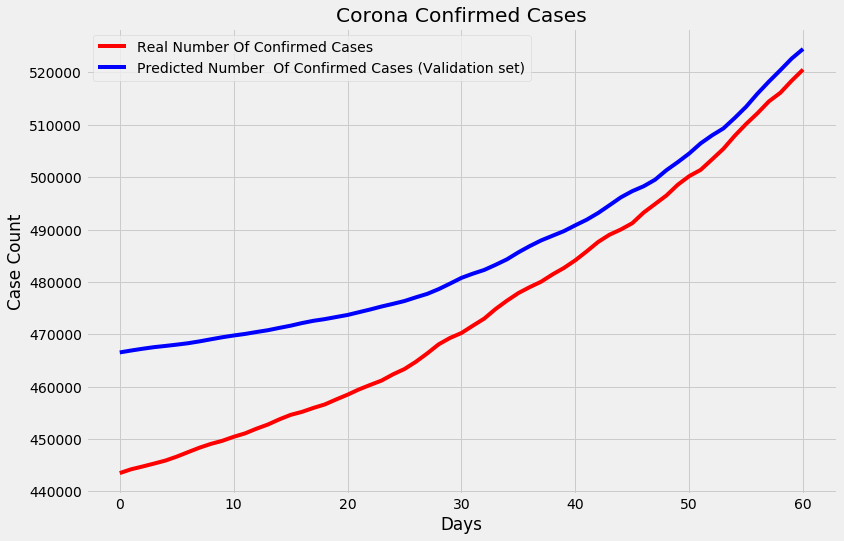

In [129]:
train_data_confirmed_cases,val_data_confirmed_cases,train_data_fatal_cases,val_data_fatal_cases =covidState.TestTrainSplit(state="New York")
x_train, y_train = covidState.createDataset(train_data_confirmed_cases.values.reshape(-1,1))
x_val, y_val = covidState.createDataset(val_data_confirmed_cases.values.reshape(-1,1))
covidState.PredictionwithLSTM(x_train, y_train,x_val, y_val )

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 2, 50)             10400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
dropout_18 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 2, 50)             20200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 2, 50)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 2, 30)           

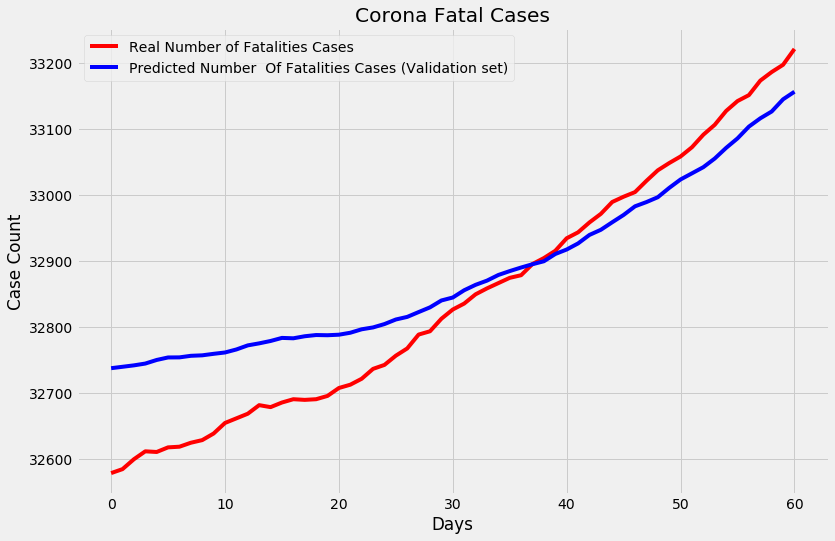

In [130]:
x_train, y_train = covidState.createDataset(train_data_fatal_cases.values.reshape(-1,1))
x_val, y_val = covidState.createDataset(val_data_fatal_cases.values.reshape(-1,1))
covidState.PredictionwithLSTM(x_train, y_train,x_val, y_val,casetype="deaths")

## USING REGRESSION ALGORTIHMS

In [145]:
result=covidState.RegressionFeatures('Texas')

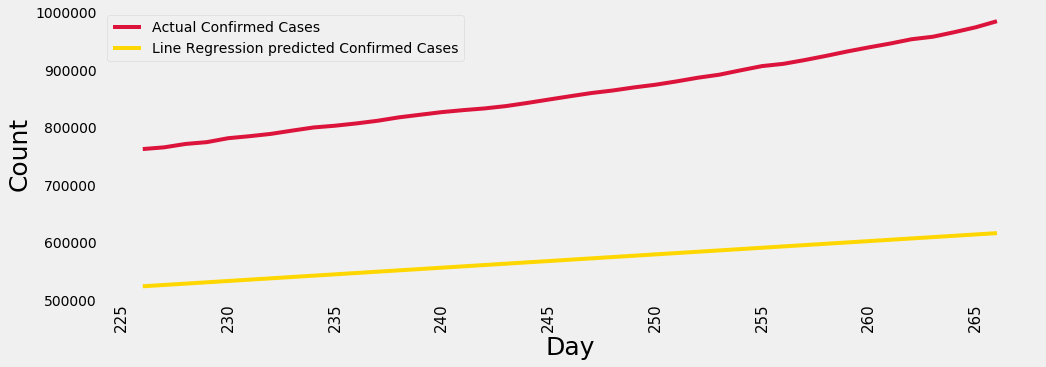

MAE: 291047.2143665012
MSE: 86054666805.61629


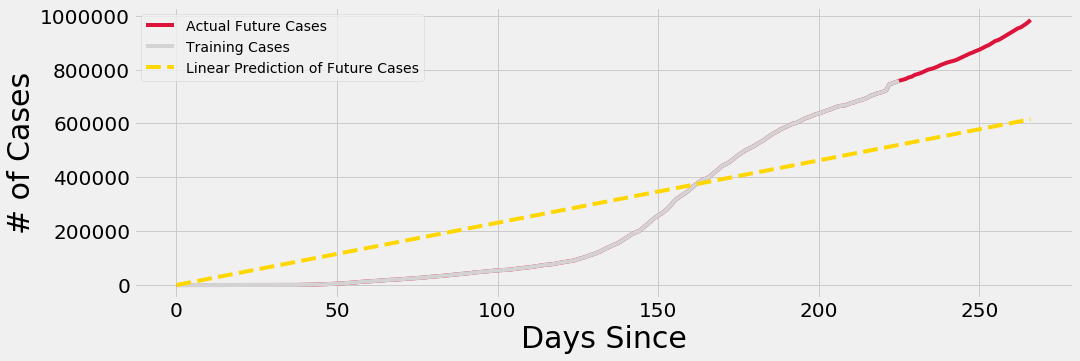

In [147]:
# Linear Regression
covidState.LinearRegression(result[0],result[1])

# Polynomial Regression

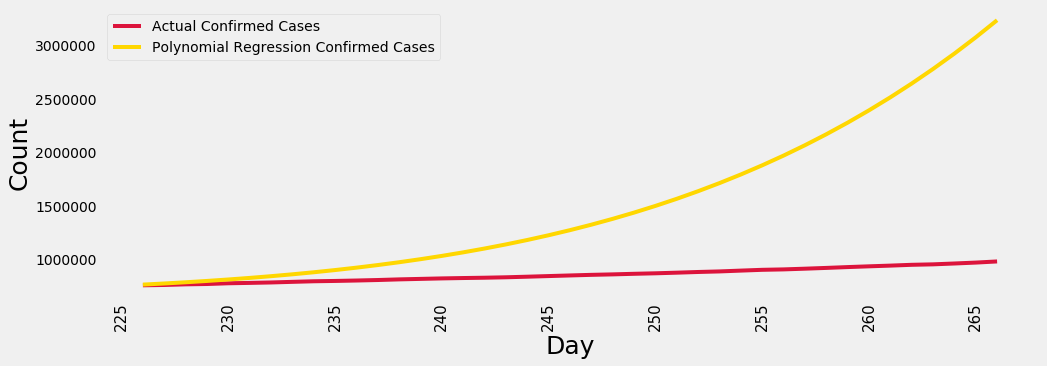

MAE: 663963.2506461405
MSE: 863927130262.3512


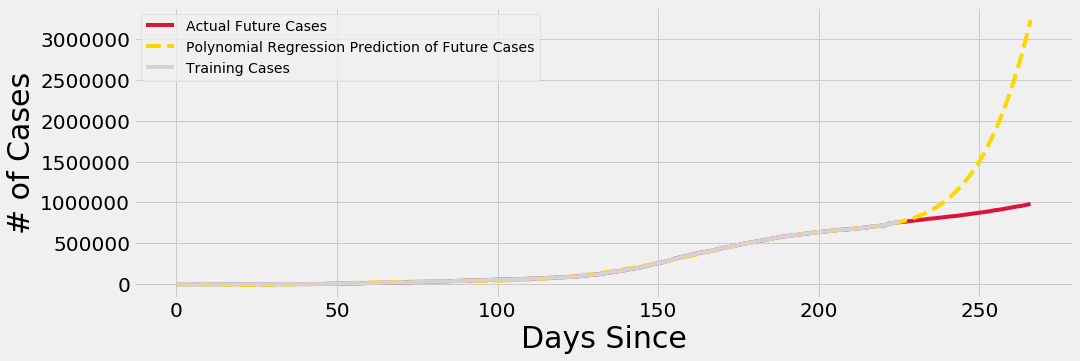

In [148]:
covidState.PolynomialRegression(result[0],result[1])

# Ridge Regression

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.8s finished


{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1': 1e-07, 'alpha_2': 1e-05, 'alpha_1': 0.0001}


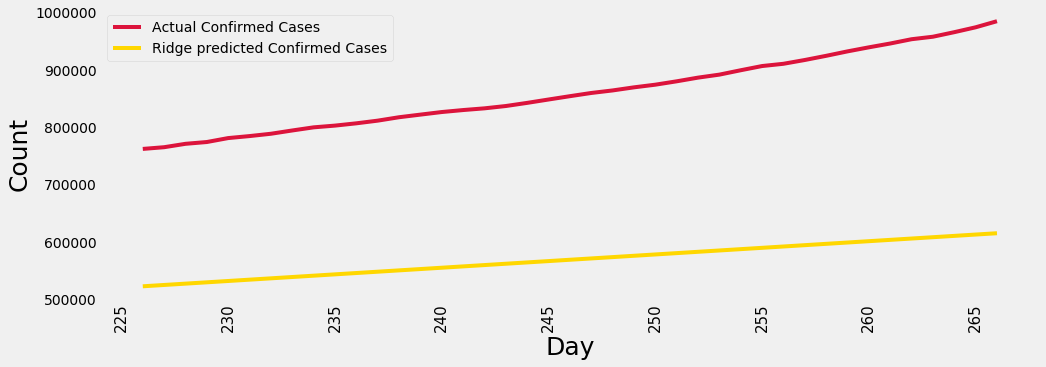

MAE: 291584.86407872214
MSE: 86369790231.71986


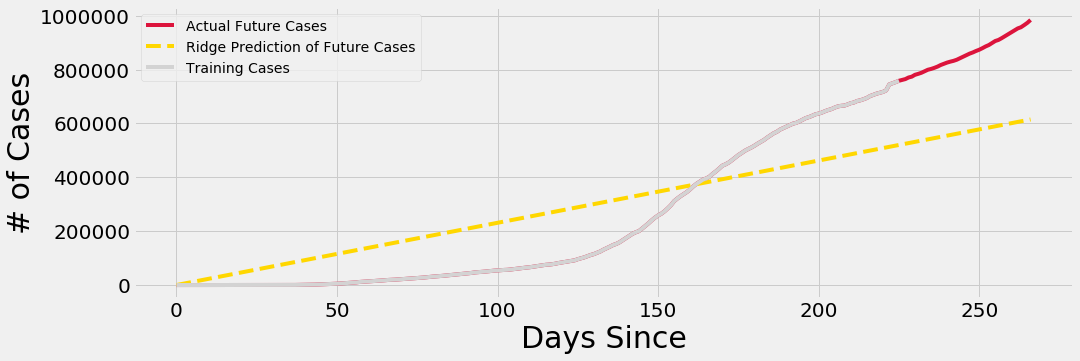

In [149]:
covidState.RidgeRegression(result[0],result[1])

# Polynomial Ridge Regression

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.01, 'lambda_2': 1e-07, 'lambda_1': 1e-06, 'alpha_2': 0.0001, 'alpha_1': 0.0001}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


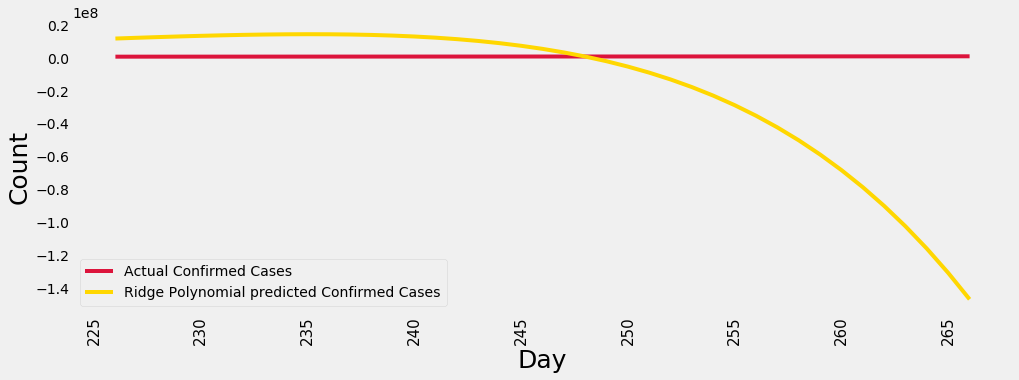

MAE: 31208592.47867491
MSE: 2375517589956704.0


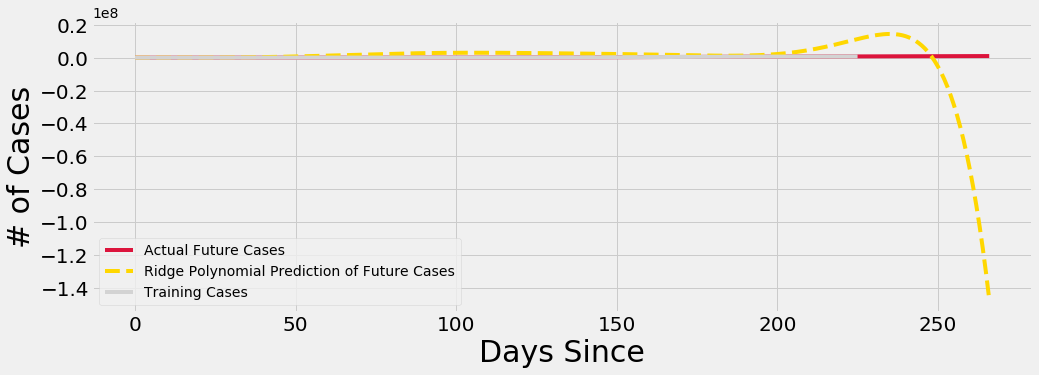

In [153]:
covidState.PolynomialRidgeRegression(result[0],result[1])

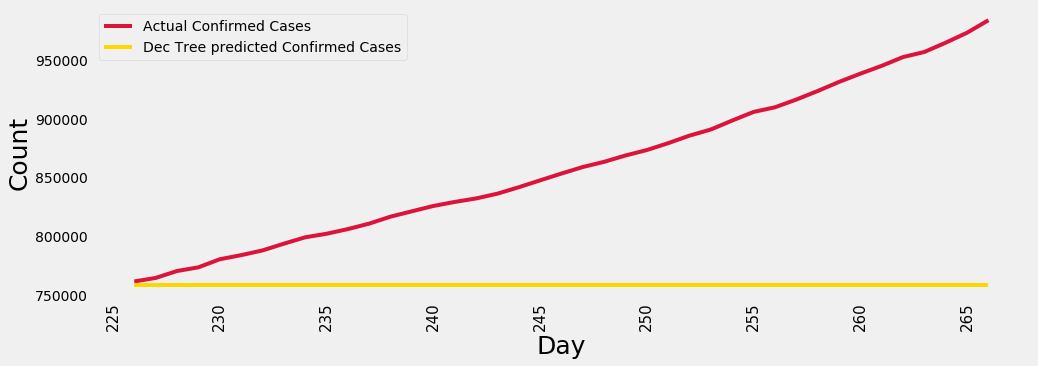

MAE: 101756.85365853658
MSE: 14430059288.024391


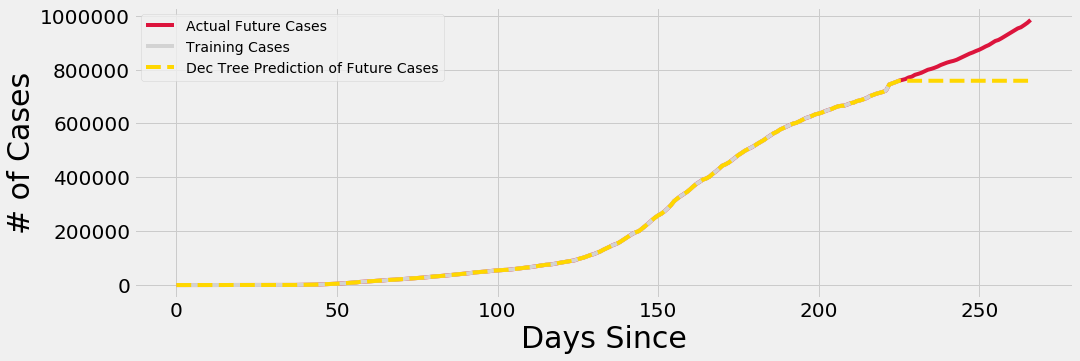

In [154]:
covidState.DecisionTree(result[0],result[1])

# Linear Regression

<class 'pandas.core.frame.DataFrame'>
length = 248 and forecast_out = 30
[-2.33711882 -2.2625792  -0.80105124 -0.53709533]
Length of X_forecast_out: 30 & Length of X : 218
Length of y:  218
length of X_train and x_test:  174 44
Accuracy of Linear Regression:  0.9705991629309471
[521616.29160718 523199.47521975 529516.59531684 530429.77480837
 531719.67346368 531642.45076249 531845.19479172 536744.93278214
 537492.80923157 540868.43831501 545549.75101364 548617.26215856
 548120.11025049 546685.67453531 550308.0956732  559163.55827998
 558515.06725193 561072.71116857 567344.64176665 567063.19556285
 565700.0717077  573926.96654137 577449.70230981 584182.68754551
 586312.61377609 588406.22935476 592698.0270975  591331.53421896
 599681.9427635  601045.95578444]


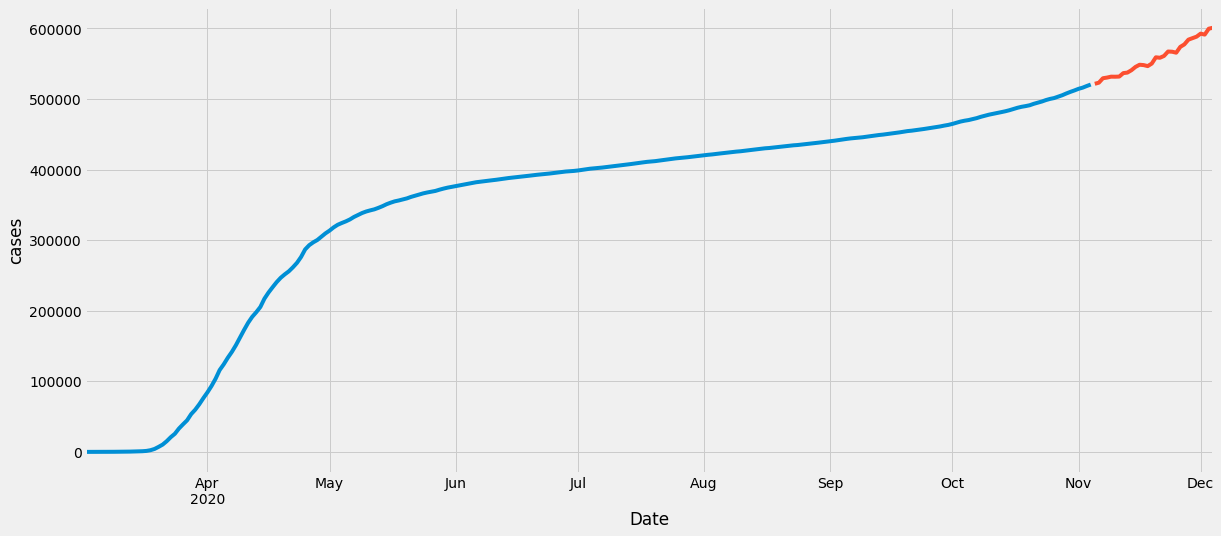

In [156]:
covidState.SimpleRegression("New York","cases",30)

<class 'pandas.core.frame.DataFrame'>
length = 248 and forecast_out = 30
[-2.33711882 -2.2625792  -0.80105124 -0.53709533]
Length of X_forecast_out: 30 & Length of X : 218
Length of y:  218
length of X_train and x_test:  174 44
Accuracy of Linear Regression:  0.9546057146526303
[34551.7505686  34524.11438106 35151.12865502 34894.94142242
 34750.35170717 34415.94141537 34275.41133465 34757.30863334
 34591.70584161 34882.03433783 35230.25177202 35356.58886904
 34913.37062686 34455.69972256 34749.68097994 35789.60428949
 35319.68265405 35367.39485335 35930.70735065 35455.712025
 34942.29334581 35939.98922918 36035.8557436  36638.93796929
 36414.1487908  36222.84222009 36489.94688947 35793.14386887
 36670.35246523 36456.55610957]


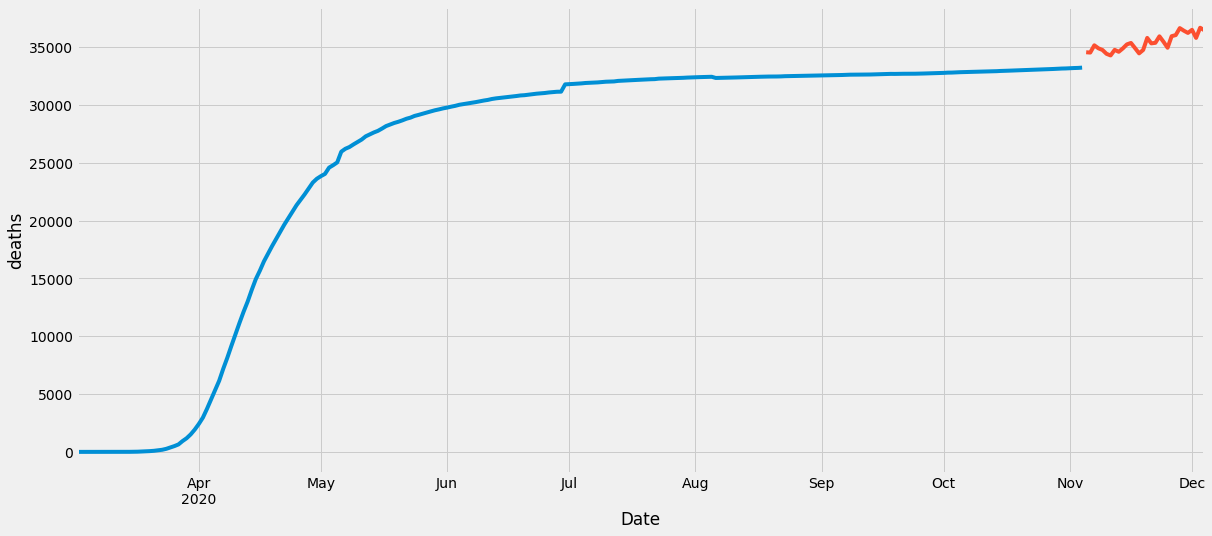

In [157]:
covidState.SimpleRegression("New York","deaths",30)

## Using FB PROPHET TimeSeries Prediction 

In [158]:
covidState.ProphetPrediction("New York","cases")

<class 'pandas.core.frame.DataFrame'>


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Using SIR MODEL Prediction

            date     state  fips   cases  deaths  newcases  newdeaths
261   2020-03-02  New York    36       1       0       0.0        0.0
276   2020-03-03  New York    36       2       0       1.0        0.0
293   2020-03-04  New York    36      11       0       9.0        0.0
313   2020-03-05  New York    36      22       0      11.0        0.0
338   2020-03-06  New York    36      44       0      22.0        0.0
...          ...       ...   ...     ...     ...       ...        ...
13357 2020-10-31  New York    36  512223   33152    2052.0        9.0
13412 2020-11-01  New York    36  514482   33174    2259.0       22.0
13467 2020-11-02  New York    36  516114   33187    1632.0       13.0
13522 2020-11-03  New York    36  518431   33198    2317.0       11.0
13577 2020-11-04  New York    36  520557   33222    2126.0       24.0

[248 rows x 7 columns]
18803891.0 109.0 0.0
18803891.0 109.0 0.0
18803891.0 109.0 0.0
18803891.0 109.0 0.0
18803891.0 109.0 0.0
18803891.0 109.0 0.0
18803891.0

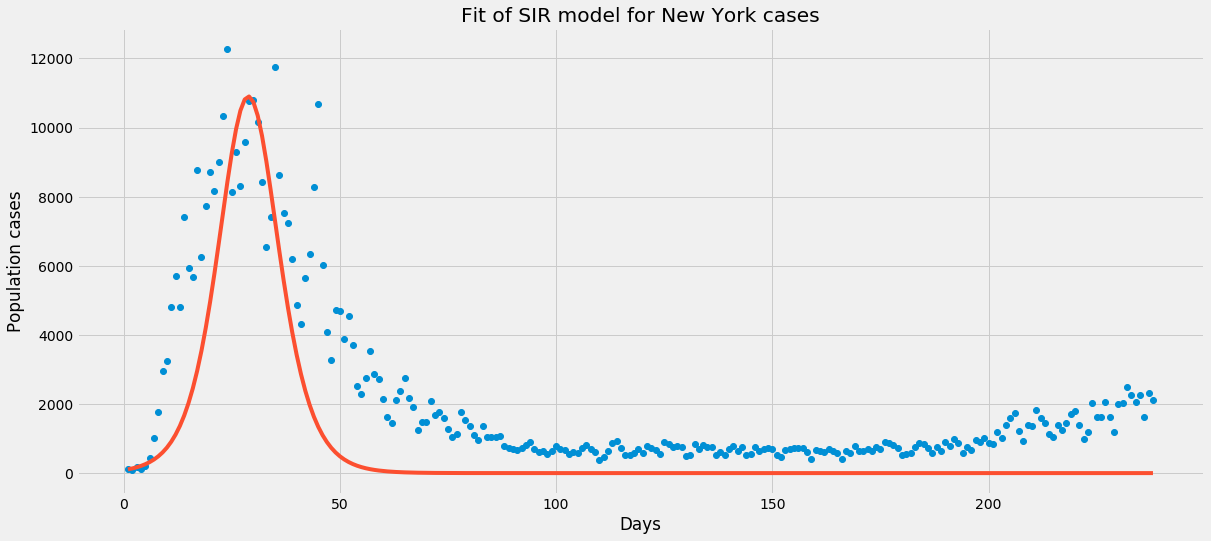

Optimal parameters: beta = 6.366580073691064  and gamma =  6.152063546340818


In [161]:
covidState.PredictionSIR(float(18804000) ,"New York",'cases')

# Prediction using ARMIA 


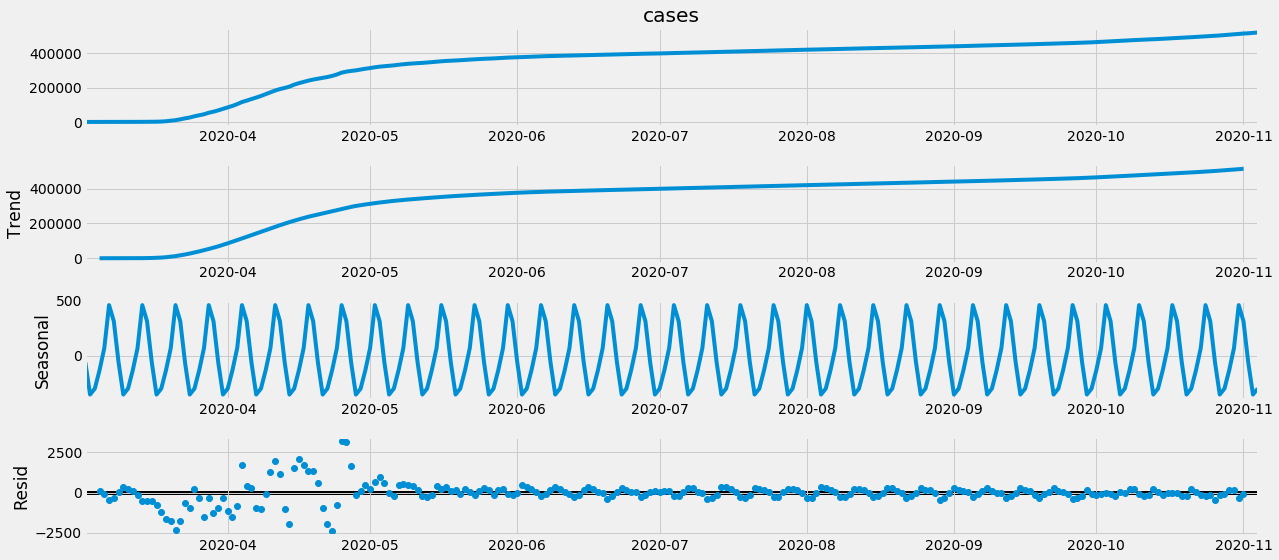

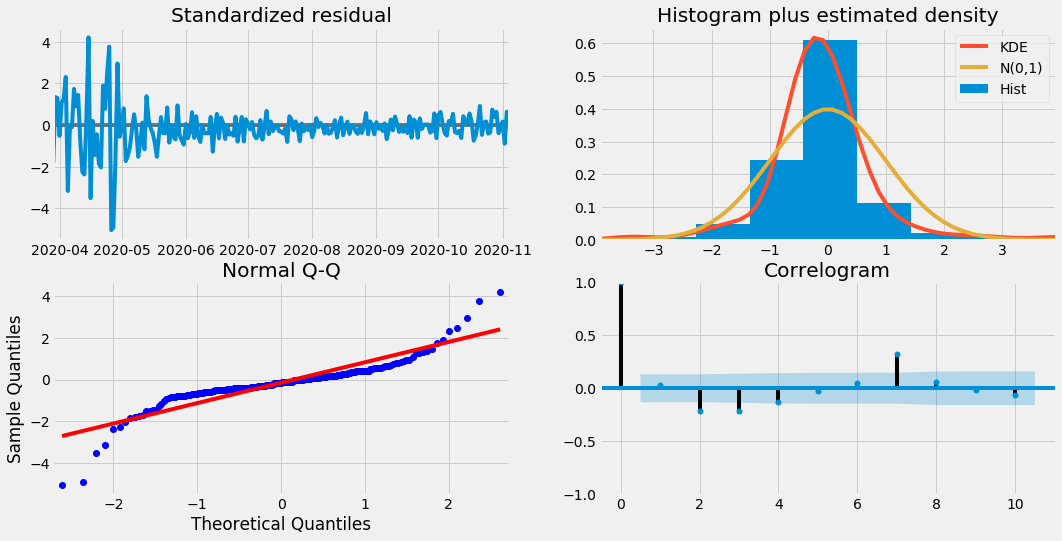

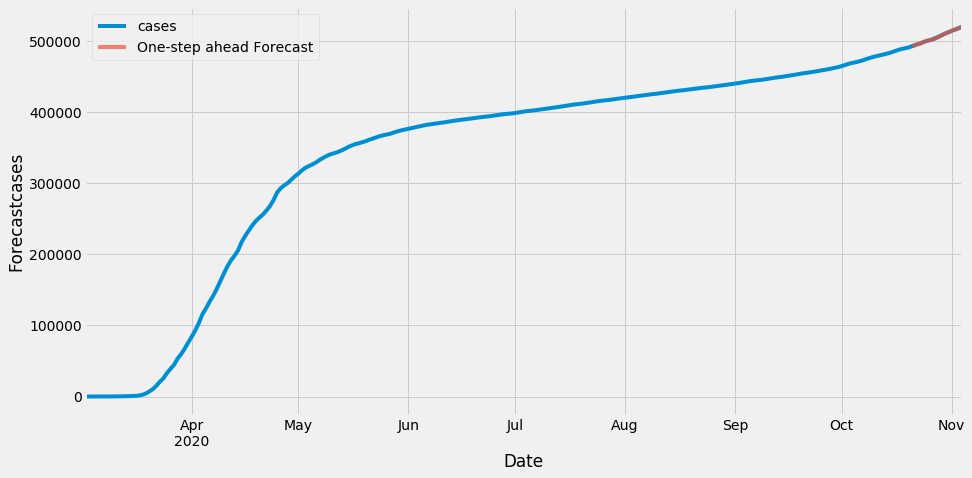

In [162]:
#  New York Cases From Today
covidState.ARIMAPrediction('New York','cases','2020-10-21')

In [ ]:
res=covidState.PredictionAnn("New York","cases")

# Using Artificial Neural Network

            date     state  fips   cases  deaths  newcases  newdeaths
261   2020-03-02  New York    36       1       0       0.0        0.0
276   2020-03-03  New York    36       2       0       1.0        0.0
293   2020-03-04  New York    36      11       0       9.0        0.0
313   2020-03-05  New York    36      22       0      11.0        0.0
338   2020-03-06  New York    36      44       0      22.0        0.0
...          ...       ...   ...     ...     ...       ...        ...
13357 2020-10-31  New York    36  512223   33152    2052.0        9.0
13412 2020-11-01  New York    36  514482   33174    2259.0       22.0
13467 2020-11-02  New York    36  516114   33187    1632.0       13.0
13522 2020-11-03  New York    36  518431   33198    2317.0       11.0
13577 2020-11-04  New York    36  520557   33222    2126.0       24.0

[248 rows x 7 columns]
             cases
date              
2020-03-02       1
2020-03-03       2
2020-03-04      11
2020-03-05      22
2020-03-06      44
...

16/16 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.0000e+00
Epoch 69/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0192 - accuracy: 0.0000e+00
Epoch 70/150
16/16 [==============================] - 0s 1ms/step - loss: 0.0193 - accuracy: 0.0000e+00
Epoch 71/150
16/16 [==============================] - 0s 1ms/step - loss: 0.0259 - accuracy: 0.0000e+00
Epoch 72/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0183 - accuracy: 0.0000e+00
Epoch 73/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0230 - accuracy: 0.0000e+00
Epoch 74/150
16/16 [==============================] - 0s 1ms/step - loss: 0.0199 - accuracy: 0.0000e+00
Epoch 75/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.0000e+00
Epoch 76/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.0000e+00
Epoch 77/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0

16/16 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.0000e+00
Epoch 147/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.0000e+00
Epoch 148/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.0000e+00
Epoch 149/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.0000e+00
Epoch 150/150
16/16 [==============================] - 0s 2ms/step - loss: 0.0172 - accuracy: 0.0000e+00


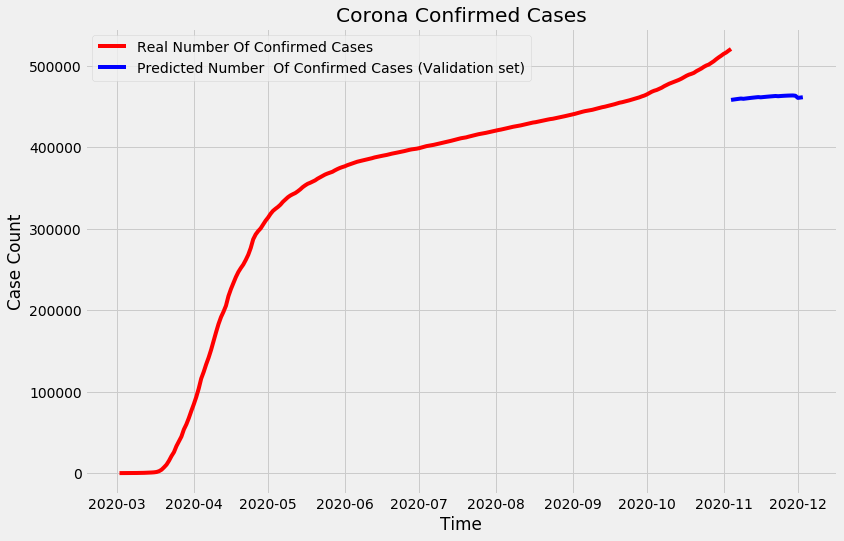

In [163]:
covidState.PredictionAnn("New York","cases")

            date     state  fips   cases  deaths  newcases  newdeaths
246   2020-03-01  New York    36       1       0       NaN        NaN
261   2020-03-02  New York    36       1       0       0.0        0.0
276   2020-03-03  New York    36       2       0       1.0        0.0
293   2020-03-04  New York    36      11       0       9.0        0.0
313   2020-03-05  New York    36      22       0      11.0        0.0
...          ...       ...   ...     ...     ...       ...        ...
13357 2020-10-31  New York    36  512223   33152    2052.0        9.0
13412 2020-11-01  New York    36  514482   33174    2259.0       22.0
13467 2020-11-02  New York    36  516114   33187    1632.0       13.0
13522 2020-11-03  New York    36  518431   33198    2317.0       11.0
13577 2020-11-04  New York    36  520557   33222    2126.0       24.0

[249 rows x 7 columns]
         date
0  2020-11-04
1  2020-11-05
2  2020-11-06
3  2020-11-07
4  2020-11-08
5  2020-11-09
6  2020-11-10
7  2020-11-11
8  2020-11

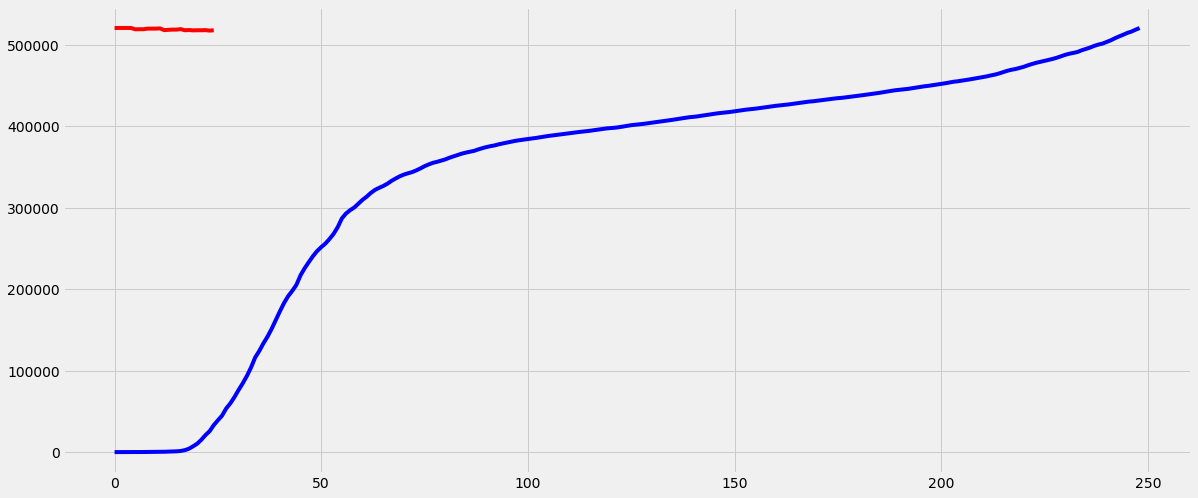

In [221]:
covidState.PredictionXGBOOST("New York","cases")

            date     state  fips   cases  deaths  newcases  newdeaths
246   2020-03-01  New York    36       1       0       NaN        NaN
261   2020-03-02  New York    36       1       0       0.0        0.0
276   2020-03-03  New York    36       2       0       1.0        0.0
293   2020-03-04  New York    36      11       0       9.0        0.0
313   2020-03-05  New York    36      22       0      11.0        0.0
...          ...       ...   ...     ...     ...       ...        ...
13357 2020-10-31  New York    36  512223   33152    2052.0        9.0
13412 2020-11-01  New York    36  514482   33174    2259.0       22.0
13467 2020-11-02  New York    36  516114   33187    1632.0       13.0
13522 2020-11-03  New York    36  518431   33198    2317.0       11.0
13577 2020-11-04  New York    36  520557   33222    2126.0       24.0

[249 rows x 7 columns]
         date
0  2020-11-04
1  2020-11-05
2  2020-11-06
3  2020-11-07
4  2020-11-08
5  2020-11-09
6  2020-11-10
7  2020-11-11
8  2020-11

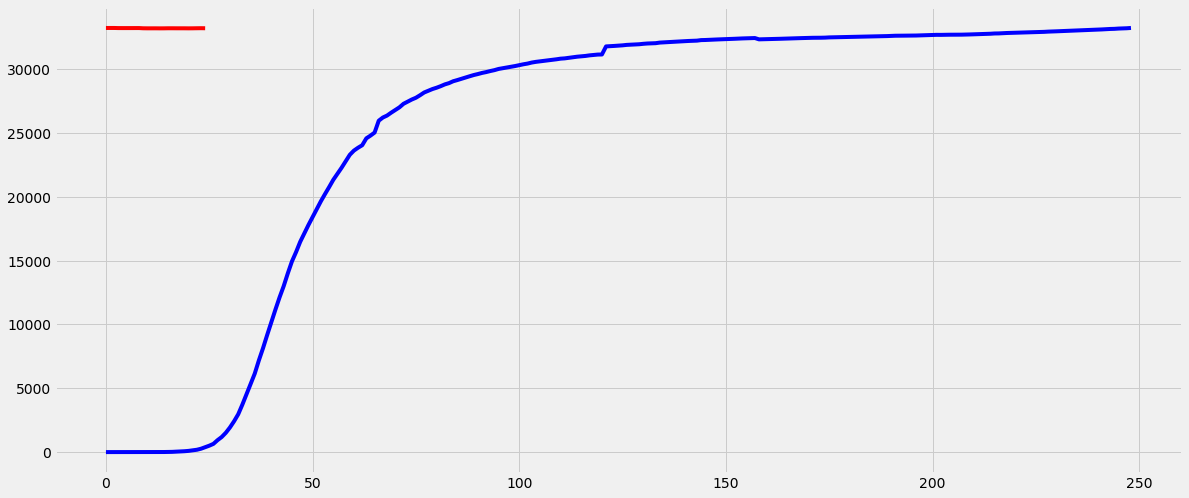

In [217]:
covidState.PredictionXGBOOST("New York","deaths")